In [1]:
!pip install gdown 
!gdown --id 1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr


/opt/conda/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr
From (redirected): https://drive.google.com/uc?id=1p79C1yIK7XEjHVpLZoJljFYDH2VSaJbr&confirm=t&uuid=d71377a8-6458-4216-859c-867e5620155e
To: /kaggle/working/Dataset.zip
100%|████████████████████████████████████████| 829M/829M [00:11<00:00, 72.6MB/s]


In [2]:
%cd /kaggle/working

/kaggle/working


In [3]:
! unzip Dataset.zip


Archive:  Dataset.zip
   creating: Dataset/
  inflating: Dataset/baomoi.model.bin  
  inflating: Dataset/wikilingual.csv  
  inflating: Dataset/vietnews_train.csv  
  inflating: Dataset/vietnews_val.csv  
  inflating: Dataset/vietnews_test.csv  


# **Import libraries**

In [4]:
import os
import pickle

import pandas as pd
import numpy as np
import time
import math
import random
import operator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from pyvi import ViTokenizer, ViPosTagger
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import KeyedVectors

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable

from queue import PriorityQueue


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# **Process data**

In [6]:
train = pd.read_csv("Dataset/vietnews_train.csv",index_col = 0)
val = pd.read_csv("Dataset/vietnews_val.csv", index_col = 0)
test = pd.read_csv("Dataset/vietnews_test.csv", index_col = 0)

In [7]:
train.drop(['file'], axis = 1, inplace = True)
val.drop(['file'], axis = 1, inplace = True)
test.drop(['file'], axis = 1, inplace = True)

In [8]:
def process(str):
    return '<sos> ' + str.lower() + ' <eos>'

In [9]:
train.original = train.original.apply(process)
val.original = val.original.apply(process)
test.original = test.original.apply(process)


In [10]:
train.summary = train.summary.apply(process)
val.summary = val.summary.apply(process)
test.summary = test.summary.apply(process)


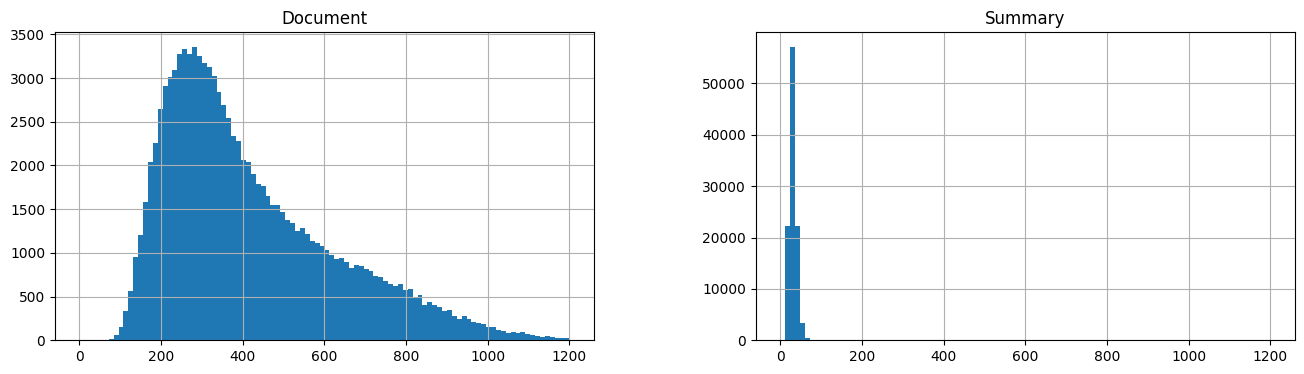

In [11]:
text_count = [len(sentence.split()) for sentence in train.original]
headlines_count = [len(sentence.split()) for sentence in train.summary]

pd.DataFrame({'Document': text_count, 'Summary': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 1200])
plt.show()


In [12]:
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)

print(get_word_percent(train.original, 800))

print(get_word_percent(train.summary, 50))


0.93
0.98


In [13]:
max_text_len = 800
max_summary_len = 50

def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['original'])
    cleaned_summary = np.array(df['summary'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


train = trim_text_and_summary(train, max_text_len, max_summary_len)
val = trim_text_and_summary(val, max_text_len, max_summary_len)
test = trim_text_and_summary(test, max_text_len, max_summary_len)

print(f'Dataset size: {len(train)}')
train.sample(5)


Dataset size: 96388


,text,summary
46395,<sos> tổng_thống mỹ donald_trump ( phải ) và n...,<sos> vùng_đệm an_ninh nhằm đảm_bảo an_toàn ch...
36576,<sos> tình_báo mỹ đang theo_dõi một loạt các c...,<sos> cả mỹ và israel đang lo_ngại một_số chuy...
8184,<sos> kate_mcclure và johnny_bobbitt_jr khi gặ...,<sos> johnny bobbitt_jr . được cộng_đồng quyên...
42286,<sos> tổng_thống mỹ barack_obama phát_biểu tại...,<sos> tổng_thống barack_obama chế_giễu donald_...
14619,<sos> đồ cúng của một_số người indonesia tin v...,<sos> gia_đình indonesia cho_rằng việc giữ thi...


In [14]:
x_train,y_train = train.text, train.summary
x_val,y_val = val.text, val.summary
x_test,y_test = test.text, test.summary


In [15]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)
x_test_sequence = x_tokenizer.texts_to_sequences(x_test)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')
x_test_padded = pad_sequences(x_test_sequence, maxlen=max_text_len, padding='post')

y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)
y_test_sequence = y_tokenizer.texts_to_sequences(y_test)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')
y_test_padded = pad_sequences(y_test_sequence, maxlen=max_summary_len, padding='post')


# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1
y_vocab_size = len(y_tokenizer.word_index) + 1
# else use this
# x_vocab_size = tokenizer.num_words + 1

print(y_vocab_size)


21946


In [16]:
SOS_token = y_tokenizer.word_index['sos']
EOS_token = y_tokenizer.word_index['eos']
PAD_index = 0
x_EOS_token = x_tokenizer.word_index['eos']
print("SOS token: ",SOS_token)
print("EOS token: ",EOS_token)


SOS token:  1
EOS token:  2


In [17]:
embedding_size = 400
word_vectors = KeyedVectors.load_word2vec_format('Dataset/baomoi.model.bin', binary=True)
num_words_x = len(x_tokenizer.word_index) + 1
x_embedding_matrix = np.zeros((num_words_x, embedding_size))
for word, i in x_tokenizer.word_index.items():
    if word in word_vectors:
        x_embedding_matrix[i] = word_vectors[word]
    else:
        x_embedding_matrix[i] = np.random.normal(size=(embedding_size,))
num_words_y = len(y_tokenizer.word_index) + 1
y_embedding_matrix = np.zeros((num_words_y, embedding_size))
for word, i in y_tokenizer.word_index.items():
    if word in word_vectors:
        y_embedding_matrix[i] = word_vectors[word]
    else:
        y_embedding_matrix[i] = np.random.normal(size=(embedding_size,))


In [18]:
import torch.utils.data as data

train_dataset = data.TensorDataset(torch.tensor(x_train_padded,dtype = torch.long).to(device), torch.tensor(y_train_padded,dtype = torch.long).to(device))
train_dataloader = data.DataLoader(train_dataset, batch_size = 64, shuffle= True)
val_dataset = data.TensorDataset(torch.tensor(x_val_padded,dtype = torch.long).to(device), torch.tensor(y_val_padded,dtype = torch.long).to(device))
val_dataloader = data.DataLoader(val_dataset, batch_size = 64, shuffle= True)
test_dataset = data.TensorDataset(torch.tensor(x_test_padded,dtype = torch.long).to(device), torch.tensor(y_test_padded,dtype = torch.long).to(device))
test_dataloader = data.DataLoader(test_dataset, batch_size = 64, shuffle= True)

# **Modelling**

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, embedding_weight):
        super().__init__()
        
        # initializations
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weight, dtype= torch.float32),requires_grad= False)
        # we will use 2 layers for both encoder and decoder
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return outputs,hidden
 

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.randn_like(torch.empty(hidden_size)))

    def forward(self, hidden, encoder_outputs):
        sequence_length = encoder_outputs.size(0)
        h = hidden.repeat_interleave(sequence_length, dim=0)
        h = h.view(sequence_length, -1, self.hidden_size).transpose(0, 1)
        encoder_outputs = encoder_outputs.transpose(0, 1)
        energy = F.relu(self.attn(torch.cat((h, encoder_outputs), dim=2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.matmul(v, energy)
        return F.softmax(energy.squeeze(1), dim=1).unsqueeze(1)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout, embedding_weight):
        super().__init__()
        
        # initialize
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_weight, dtype=torch.float32), requires_grad=False)

        # for decoder we will use n_directions 1
        self.rnn = nn.LSTM(emb_dim + hid_dim, hid_dim, n_layers, dropout=dropout)
        # fully connected layer to predict words
        self.fc_out = nn.Linear(hid_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.attention = Attention(hid_dim)


    def forward(self, trg, hidden, encoder_outputs):
        # trg = [batch size]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # encoder_outputs = [src len, batch size, hid dim]

        # n directions in the decoder will always be 1, therefore:
        # hidden = [n layers, batch size, hid dim]
        # context = [n layers, batch size, hid dim]
        (hidden,cell) = hidden

        # trg = [1, batch size]

        embedded = self.dropout(self.embedding(trg).unsqueeze(0))

        # embedded = [1, batch size, emb dim]

        # Calculate attention scores
        attn_weights = self.attention(hidden[-1], encoder_outputs)  # [32, 512][27, 32, 512]=>[32, 1, 27]
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N) # [32, 1, 27]bmm[32, 27, 512]=>[32,1,512]
        context = context.transpose(0, 1)  # (1,B,N) # [32, 1, 512]=>[1, 32, 512]
        # Combine embedded input word and attended context, run through RNN
        rnn_input = torch.cat([embedded, context], 2)  # [1, 32, 256] cat [1, 32, 512]=> [1, 32, 768]

        output, hidden = self.rnn(rnn_input, (hidden, cell))

        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        # seq len and n directions will always be 1 in the decoder, therefore:
        # output = [1, batch size, hid dim]
        # hidden = [n layers, batch size, hid dim]
        # cell = [n layers, batch size, hid dim]
        output = output.squeeze(0)  # (1,B,N) -> (B,N)
        context = context.squeeze(0)
        output = self.fc_out(torch.cat([output, context], 1))  # [32, 512] cat [32, 512] => [32, 512*2]
        output = F.log_softmax(output, dim=1)


        # prediction = [batch size, output dim]

        return output, hidden

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, beam_size=5):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.beam_size = beam_size
        
        assert encoder.hid_dim == decoder.hid_dim, "Hidden dimensions of encoder and decoder must be equal!"
        #assert encoder.n_layers == decoder.n_layers, "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        #src = [src len, batch size] where src_len is number of tokens in source sentence
        #trg = [trg len, batch size] same for trg_len
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim # we don't have trg.shape[-1] here
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        encoder_outputs, (hidden, cell) = self.encoder(src)
        hidden, cell = hidden[:self.decoder.n_layers], cell[:self.decoder.n_layers]
        #first input to the decoder is the <sos> tokens
        dec_input = trg[0,:]
        

        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            
            output, (hidden, cell) = self.decoder(dec_input, (hidden, cell), encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            dec_input = trg[t] if teacher_force else top1
        
        return outputs
    def decode(self, src, trg, method='beam-search'):
        encoder_output, (hidden, cell) = self.encoder(src)  # [27, 32]=> =>[27, 32, 512],[4, 32, 512]
        hidden, cell = hidden[:self.decoder.n_layers], cell[:self.decoder.n_layers]  # [4, 32, 512][1, 32, 512]
        if method == 'beam-search':
            return self.beam_decode(trg, (hidden,cell), encoder_output)
        else:
            return self.greedy_decode(trg, (hidden, cell), encoder_output)

    def greedy_decode(self, trg, decoder_hidden, encoder_outputs, ):
        '''
        :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
        :param decoder_hidden: input tensor of shape [1, B, H] for start of the decoding
        :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
        :return: decoded_batch
        '''
        seq_len, batch_size = trg.size()
        decoded_batch = torch.zeros((batch_size, seq_len))
        # decoder_input = torch.LongTensor([[EN.vocab.stoi['<sos>']] for _ in range(batch_size)]).cuda()
        decoder_input = Variable(trg.data[0, :]).cuda()  # sos
        print(decoder_input.shape)
        for t in range(seq_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)

            topv, topi = decoder_output.data.topk(1)  # [32, 10004] get candidates
            topi = topi.view(-1)
            decoded_batch[:, t] = topi

            decoder_input = topi.detach().view(-1)

        return decoded_batch


    def beam_decode(self, target_tensor, decoder_hiddens, encoder_outputs=None):
        '''
        :param target_tensor: target indexes tensor of shape [B, T] where B is the batch size and T is the maximum length of the output sentence
        :param decoder_hiddens: input tensor of shape [1, B, H] for start of the decoding
        :param encoder_outputs: if you are using attention mechanism you can pass encoder outputs, [T, B, H] where T is the maximum length of input sentence
        :return: decoded_batch
        '''
        target_tensor = target_tensor.permute(1, 0)
        beam_width = 10
        topk = 1  # how many sentence do you want to generate
        decoded_batch = []

        # decoding goes sentence by sentence
        for idx in range(target_tensor.size(0)):  # batch_size
            if isinstance(decoder_hiddens, tuple):  # LSTM case
                decoder_hidden = (
                    decoder_hiddens[0][:, idx, :].unsqueeze(0), decoder_hiddens[1][:, idx, :].unsqueeze(0))
            else:
                decoder_hidden = decoder_hiddens[:, idx, :].unsqueeze(0)  # [1, B, H]=>[1,H]=>[1,1,H]
            encoder_output = encoder_outputs[:, idx, :].unsqueeze(1)  # [T,B,H]=>[T,H]=>[T,1,H]

            # Start with the start of the sentence token
            decoder_input = torch.LongTensor([SOS_token]).cuda()

            # Number of sentence to generate
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))

            # starting node -  hidden vector, previous node, word id, logp, length
            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()

            # start the queue
            nodes.put((-node.eval(), node))
            qsize = 1

            # start beam search
            while True:
                # give up when decoding takes too long
                if qsize > 2000: break

                # fetch the best node
                score, n = nodes.get()
                # print('--best node seqs len {} '.format(n.leng))
                decoder_input = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == EOS_token and n.prevNode != None:
                    endnodes.append((score, n))
                    # if we reached maximum # of sentences required
                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # decode for one step using decoder
                decoder_output, decoder_hidden  = self.decoder(decoder_input, decoder_hidden, encoder_output)

                # PUT HERE REAL BEAM SEARCH OF TOP
                log_prob, indexes = torch.topk(decoder_output, beam_width)
                nextnodes = []

                for new_k in range(beam_width):
                    decoded_t = indexes[0][new_k].view(-1)
                    log_p = log_prob[0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))

                # put them into queue
                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))
                    # increase qsize
                qsize += len(nextnodes) - 1

            # choose nbest paths, back trace them
            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back trace
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            decoded_batch.append(utterances)

        return decoded_batch


class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward  # 注意这里是有惩罚参数的，参考恩达的 beam-search

    def __lt__(self, other):
        return self.leng < other.leng  # 这里展示分数相同的时候怎么处理冲突，具体使用什么指标，根据具体情况讨论

    def __gt__(self, other):
        return self.leng > other.leng

In [20]:
from tqdm import tqdm
import time
import math
class Seq2Seq_trainer(object):
    def __init__(self, model, train_iterator, valid_iterator, pad_index, device, clip, learning_rate):
        # initialize config variables
        self.model = model.to(device)
        self.train_iterator = train_iterator
        self.valid_iterator = valid_iterator
        self.clip = clip
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
        self.criterion = nn.CrossEntropyLoss(ignore_index = pad_index)
        self.model.apply(self.init_weights)
        print(f'The model has {self.count_parameters(self.model):,} trainable parameters')

        
    
    def init_weights(self,m):
        for name, param in m.named_parameters():
            nn.init.uniform_(param.data, -0.08, 0.08)
        
    
    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    
    def train(self):

        self.model.train()

        epoch_loss = 0
        num_batches = max((i, j) for i, j in enumerate(self.train_iterator))[0]

        for i, batch in enumerate(self.train_iterator):

            src = batch[0].transpose(0, 1)
            trg = batch[1].transpose(0, 1)


            self.optimizer.zero_grad()

            output = self.model(src, trg)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = self.criterion(output, trg)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip)

            self.optimizer.step()

            epoch_loss += loss.item()
            
            if i % 100 == 0 and i != 0:
                epoch_loss = epoch_loss / 100
                print("[%d/%d][loss:%5.2f][pp:%5.2f]" %
                      (i, num_batches, epoch_loss, math.exp(epoch_loss)))
        return epoch_loss / len(self.train_iterator)
    
    
    def evaluate(self, iterator):

        self.model.eval()

        epoch_loss = 0

        with torch.no_grad():

            for i, batch in enumerate(iterator):

                src = batch[0].transpose(0, 1)
                trg = batch[1].transpose(0, 1)

                output = self.model(src, trg, 0) #turn off teacher forcing

                #trg = [trg len, batch size]
                #output = [trg len, batch size, output dim]

                output_dim = output.shape[-1]

                output = output[1:].view(-1, output_dim)
                trg = trg[1:].reshape(-1)

                #trg = [(trg len - 1) * batch size]
                #output = [(trg len - 1) * batch size, output dim]

                loss = self.criterion(output, trg)

                epoch_loss += loss.item()

        return epoch_loss / len(iterator)
    
    
    def epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs
    
    
    def fit(self, nepochs):
        best_valid_loss = float('inf')

        for epoch in tqdm(range(nepochs)):

            start_time = time.time()

            train_loss = self.train()
            valid_loss = self.evaluate(self.valid_iterator)

            end_time = time.time()

            epoch_mins, epoch_secs = self.epoch_time(start_time, end_time)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                # torch.save(model.state_dict(), 'tut1-model.pt')
                print(f'Epoch with best validation loss: {epoch+1:02}')

            print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

            
    def predict(self, iterator):
        self.model.eval()
        decoded_batch_list = []
        with torch.no_grad():

            for i, batch in enumerate(tqdm(iterator)):

                src = batch[0].transpose(0, 1)
                trg = batch[1].transpose(0, 1)

                decoded_batch = self.model.decode(src, trg, method='beam-search')
                decoded_batch.to('cpu').numpy()
                decoded_batch_list.append(decoded_batch)
                
        return decoded_batch_list


In [21]:
def get_sentence(arr, y_tokenizer):
  output = ''
  for element in arr:
    if element != 0:
      output = output + y_tokenizer.index_word[element] + ' '
  return output

# **Attention Seq2seq: BiLSTM with attention and Beam search inference**

In [22]:
INPUT_DIM = x_vocab_size
OUTPUT_DIM = y_vocab_size
ENC_EMB_DIM = 400
DEC_EMB_DIM = 400
HID_DIM = 200
N_LAYERS = 2
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

# initialize seq2seq model
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT, x_embedding_matrix)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, 1, DEC_DROPOUT, y_embedding_matrix)
attn_model = Seq2Seq(enc, dec, device)

pad_index = 0
# initialize trainer
attn_trainer = Seq2Seq_trainer(attn_model, train_dataloader, val_dataloader, pad_index, device, 1, 1e-3)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


The model has 10,325,546 trainable parameters


In [23]:
attn_trainer.fit(1)

  0%|          | 0/1 [00:00<?, ?it/s]

[100/1506][loss: 7.38][pp:1600.71]
[200/1506][loss: 7.05][pp:1150.26]
[300/1506][loss: 7.02][pp:1121.59]
[400/1506][loss: 7.00][pp:1095.86]
[500/1506][loss: 6.98][pp:1075.33]
[600/1506][loss: 6.98][pp:1071.96]
[700/1506][loss: 6.94][pp:1030.79]
[800/1506][loss: 6.90][pp:995.39]
[900/1506][loss: 6.98][pp:1079.98]
[1000/1506][loss: 6.83][pp:929.24]
[1100/1506][loss: 6.81][pp:907.23]
[1200/1506][loss: 6.78][pp:883.11]
[1300/1506][loss: 6.78][pp:882.42]
[1400/1506][loss: 6.71][pp:822.71]
[1500/1506][loss: 6.63][pp:760.39]


100%|██████████| 1/1 [36:43<00:00, 2203.81s/it]

Epoch with best validation loss: 01
Epoch: 01 | Time: 36m 43s
	Train Loss: 0.031 | Train PPL:   1.031
	 Val. Loss: 6.859 |  Val. PPL: 952.078


In [24]:
test_loss = attn_trainer.evaluate(test_dataloader)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')


	 Test. Loss: 6.854 |  Test. PPL: 948.065


In [25]:
def predict(trainer, iterator):
    trainer.model.eval()
    decoded_batch_list = []
    with torch.no_grad():

        for i, batch in enumerate(tqdm(iterator)):

            src = batch[0].transpose(0, 1)
            trg = batch[1].transpose(0, 1)

            decoded_batch = trainer.model.decode(src, trg, method='beam-search')
            decoded_batch_list.append(decoded_batch)

    return decoded_batch_list


In [26]:
test_tensor = predict(attn_trainer, test_dataloader)

100%|██████████| 323/323 [1:51:34<00:00, 20.73s/it]


In [31]:
for sentence_index in test_tensor[3]:
    decode_text_arr = [y_tokenizer.index_word[int(i.to('cpu'))] for i in sentence_index[0]]
    decode_stentence = " ".join(decode_text_arr[1:-1])
    print("pred target : {}".format(decode_stentence))


pred target : một số bay của cho biết cho biết đã được cho biết cho biết đã được cho
pred target : tổng thống mỹ trung quốc cho rằng trung quốc
pred target : sau khi công an tp hcm cho biết công an tp hcm đã tp hcm đã tp hcm công an tp hcm đã
pred target : tổng thống mỹ triều tiên tổng thống mỹ triều tiên tổng thống mỹ triều tiên triều tiên triều tiên triều tiên
pred target : tổng thống mỹ triều tiên trung quốc cho
pred target : sau khi công an tp hcm tp hcm tp hcm tp hcm tp hcm đã tp hcm đã tp hcm đã
pred target : sau khi công an tp hcm tp hcm tp hcm tp hcm tp hcm đã tp hcm đã tp hcm đã
pred target : sau khi thông tin giao thông tin giao thông tin giao thông tin giao thông tin giao thông tin giao thông tin giao thông tin giao thông tin giao thông tin
pred target : sau khi công an tp hcm cho biết công an tp hcm đã tp hcm đã tp hcm đã tp hcm công an tp hcm
pred target : tổng thống mỹ triều tiên triều tiên triều tiên triều tiên triều tiên triều tiên triều tiên triều tiên
pred target : sa

In [28]:
print("Text: ", x_test[4])
print("Predict summary: ", get_sentence(test_out_attn[4], y_tokenizer))
print("True summary: ", y_test[4])

Text:  <sos> sau khi đẻ rơi trên đường , mẹ con sản_phụ nguyễn_thị_hằng được 2 thanh_niên cùng quê chở đến bệnh_viện , hiện sức_khoẻ bình_phục . ảnh : giang_chinh 2h ngày 28/4 , chị nguyễn_thị_hằng ( 26 tuổi , trú xã tân_dương , thuỷ_nguyên , tp hải_phòng ) kêu đau đẻ , được chồng chở bằng xe_máy đến bệnh_viện đa_khoa huyện thuỷ_nguyên . ra khỏi nhà khoảng 2 km , chị hằng trở_dạ và sinh luôn trên đường , đoạn thuộc khu_phố mới , xã thuỷ_sơn . trong đêm_tối , người chồng để vợ nằm xuống đất và đỡ_đẻ . bé gái 3,3 kg chào_đời khoẻ_mạnh . không gọi được taxi cũng như xe cấp_cứu , người chồng ôm con đứng vẫy ôtô qua_lại , nhưng không ai dừng xe . bà văn_thị_thoa , mẹ chị hằng kể , khi đi xe_máy đến_nơi , bà thấy con đã sinh , nằm sõng_soài dưới đất , còn chồng ủ ấm cho cháu bé . hai mẹ_con vẫy xe nhưng không được . " tôi đã nghĩ nếu không có xe , trời mưa nặng hạt hơn sẽ phải gõ_cửa , làm_phiền nhà dân thì chiếc ôtô màu đen chạy tới . 2 thanh_niên trên xe bước xuống , hỏi chuyện , rồi đưa 2

NameError: name 'test_out_attn' is not defined